In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower')
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/final/lib/midi')
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece


import helper


ImportError: cannot import name 'process_midi_to_note_info' from 'midi' (unknown location)

In [3]:
# Return hidden score states 

note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=True)
score, time_to_next, something = dict_to_frequency_list(dic)
print(score)

[[262], [262, 330], [262, 330, 392], [523, 262, 330, 392], [330, 523, 659, 262, 392], [330, 523, 392, 659, 262], [330, 523, 392, 659, 262], [330, 523, 659, 392, 262], [330, 523, 659, 392, 262], [523, 659, 392, 262, 330], [523, 659, 392, 262, 330], [659, 523, 392, 262, 330], [659, 523, 392, 262, 330], [392, 659, 523, 262, 330], [392, 659, 523, 262, 330], [659, 392, 523, 262, 330], [392, 659, 523, 262], [523, 659, 294, 262], [262, 659, 440, 294], [659, 440, 294, 262, 587], [440, 294, 698, 262, 587], [294, 698, 262, 440, 587], [587, 294, 698, 262, 440], [587, 294, 262, 440, 698], [587, 294, 262, 440, 698], [587, 294, 262, 440, 698], [587, 294, 440, 262, 698], [587, 294, 440, 262, 698], [587, 294, 440, 262, 698], [587, 440, 294, 262, 698], [587, 440, 294, 262, 698], [587, 440, 294, 262, 698], [587, 440, 294, 247, 698], [698, 294, 247, 587], [392, 587, 294, 247, 698], [392, 294, 247, 587, 698], [392, 698, 294, 247, 587], [698, 294, 247, 392, 587], [698, 294, 247, 392, 587], [294, 247, 698, 

In [4]:
print(time_to_next)



[196.61458333333331, 197.91666666666669, 197.91666666666669, 196.61458333333326, 197.91666666666674, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666674, 196.61458333333326, 197.91666666666652, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666652, 196.61458333333348, 197.91666666666652, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666697, 196.61458333333303, 197.91666666666697, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666606, 196.61458333333394, 197.91666666666606, 197.91666666666788, 196.61458333333212, 197.91666666666788, 197.91666666666606, 197.91666666666606,

In [5]:
# Create cov_dict

cov_dict = {}
sample_length = 700
sample_rate = 44100
M=9
T=0.465
v=2.37
sigma_f=5
sigma_n=0.1
time_samples = np.linspace(0, sample_length/sample_rate, sample_length)

for state in score[:20]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            time_samples, time_samples, M=M,  f=state, sigma_f=sigma_f, T=T, v=v) + sigma_n**2 * np.eye(sample_length)

In [6]:
# Create state transmission matrix, T. Here we are using uniform distribution as all notes are the same length

# For now we will go with a very simple uniform distribution to the current or next state
K = len(score[:130]) # The number of states, K
T = np.full((K, K), -np.inf) 
for i in range(K-1): # Populate transition probabilities except final row
    T[i][i], T[i][i+1] = np.log(0.5), np.log(0.5)
T[-1][-1] = np.log(1) # Update final row so transition probability is one, to itself



In [34]:
print(T)

[[-0.69314718 -0.69314718        -inf ...        -inf        -inf
         -inf]
 [       -inf -0.69314718 -0.69314718 ...        -inf        -inf
         -inf]
 [       -inf        -inf -0.69314718 ...        -inf        -inf
         -inf]
 ...
 [       -inf        -inf        -inf ... -0.69314718 -0.69314718
         -inf]
 [       -inf        -inf        -inf ...        -inf -0.69314718
  -0.69314718]
 [       -inf        -inf        -inf ...        -inf        -inf
   0.        ]]


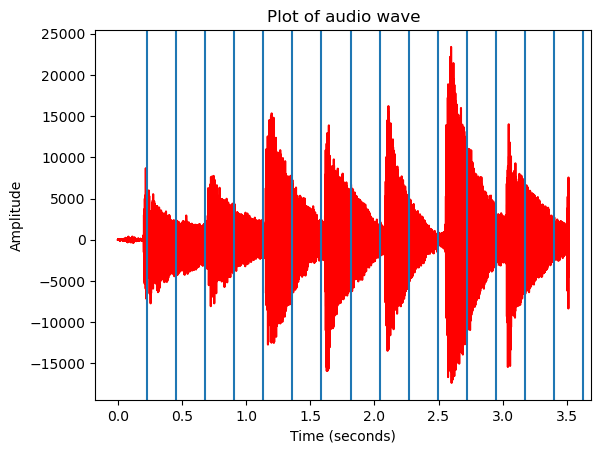

In [18]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 10000

show = 155000
offset = 10000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/Bach_3.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:16]:
    plt.axvline(i/sample_rate)


In [19]:
def viterbi(y: List[np.ndarray], T: np.ndarray, states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """

    sample_length = len(y[0]) # Assuming all samples are the same length
    K = T.shape[0] # Number of states
    n = len(y) # Number of audio samples
    gamma = np.full((K, n), -np.inf, 'd') # Matrix to hold probabilities
    delta = np.zeros((K, n), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    max_s = 0
    path = []
    w = 6
    chunk = 0
    step = w //3
    counter = []
    d = 1 # d tracks the duration number (ie this incremements each time we perform a self transition)
    
  
    # Initialise prior state (we will assume we start at the first state)
    # TODO think about the inital state and decide what to do about the silence at first
    lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)
    gamma[0,0] = 1 * lml # Initialise probability of first audio sample with state 1

    # Iterate through observations
    for i in range(1, n):
        k0_index = chunk * step
        for k in range(k0_index, k0_index + w):

            lml = -helper.stable_nlml(time_samples, y[i], M=9, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
            
            # same_state = lml + gamma[k,i-1] + T[k, k]
            same_state = lml + gamma[k,i-1]
            # advance_state = lml + gamma[k-1, i-1] + T[k-1, k]
            advance_state = lml + gamma[k-1, i-1] 
            if same_state >= advance_state:
                gamma[k, i] = same_state
                delta[k, i] = k
            else:
                gamma[k, i] = advance_state
                delta[k, i] = k - 1

        new_s = np.argmax(gamma[:,i])
        if new_s == max_s:
            d +=1
        else:
            counter.append(d)
            conversion_rates = 1000 * np.array(counter)/ np.array(time_to_next[:len(counter)]) # Multiply by 1000 to make seconds
            conversion_rate =  np.mean(conversion_rates) # Conversion is how many durations counts d per second. We take the running mean average
            d = 1
        max_s = new_s
        print(max_s, flush=True)
        path.append(max_s)
        if max_s >= k0_index + w - step:
            chunk += 1
            print('new chunk!: ', chunk)
    
    # Build the optimal path, for comparison to live output
    optimal_path = np.zeros(n, 'B')
    optimal_path[-1] = np.argmax(gamma[:, n-1])

    for i in reversed(range(1, n)):
        optimal_path[i-1] = delta[optimal_path[i], i]

    return path, optimal_path, counter


path, optimal, counter = viterbi(audio_data[:50], T, score[:50], cov_dict=cov_dict )
print(path, optimal)

    

0
2
2
2
2
2
3
3
4
new chunk!:  1
5
2
2
3
3
4
5
2
2
2
2
2
2
3
3
4
5
2
2
3
3
4
5
2
2
2
2
2
3
4
4
5
7
new chunk!:  2
7
9
new chunk!:  3
9
9
9
9
9
[0, 2, 2, 2, 2, 2, 3, 3, 4, 5, 2, 2, 3, 3, 4, 5, 2, 2, 2, 2, 2, 2, 3, 3, 4, 5, 2, 2, 3, 3, 4, 5, 2, 2, 2, 2, 2, 3, 4, 4, 5, 7, 7, 9, 9, 9, 9, 9, 9] [0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 4 5 6 7 8 9 9 9 9 9 9]


In [37]:
print(counter)

[1, 1, 5, 3, 1, 1, 3, 2]


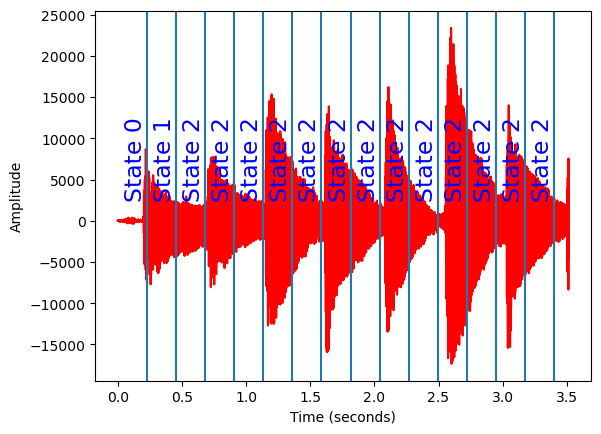

In [20]:
# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
plt.title("")
for _, i in enumerate(sample_indices[:15]):
    plt.axvline(i/sample_rate)
    plt.text(sample_indices[_]/sample_rate, 2400, f'State {optimal[_]}', color='blue', ha='right', va='bottom', rotation=90, fontsize=17)
    